Example notebook to generate Fig. 6 (sky plot of galaxies in Coma) from EDR TF paper.

In [1]:
import numpy as np

from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.visualization.wcsaxes import SphericalCircle
import astropy.units as u
import astropy.constants as const

import matplotlib.pyplot as plt

import ligo.skymap.plot

In [2]:
c = const.c.to('km/s')

# Data

In [3]:
hdul = fits.open('fig6_data.fits')

hdr = hdul[0].header
TF_gals = hdul['TF'].data
FP_gals = hdul['FP'].data

hdul.close()

In [4]:
H0 = hdr['H0']

In [5]:
#- Get Coma cluster coordinates
Coma_coords = SkyCoord(ra=hdr['COMA_RA'], dec=hdr['COMA_DEC'], unit='deg', frame='icrs')

sigma_Coma = hdr['COMA_SIG']
V_Coma = hdr['COMA_V']
z_Coma = hdr['COMA_Z']

R2t_Coma = hdr['COMA_R2T']
R2t_Coma_angle_1p5 = np.arctan(1.5*R2t_Coma/(V_Coma/H0))*u.radian
R2t_Coma_angle_3 = np.arctan(3*R2t_Coma/(V_Coma/H0))*u.radian

In [6]:
#- Get Coma galaxy coordinates
tf_coords = SkyCoord(ra=TF_gals['RA'], dec=TF_gals['DEC'], unit='deg', frame='icrs')
fp_coords = SkyCoord(ra=FP_gals['RA'], dec=FP_gals['DEC'], unit='deg', frame='icrs')

# Plot

In [7]:
# Define the redshift histogram bins so that they are centered around the cluster's redshift
bin_width = 0.0025
Nbins = 9

z_bins = np.arange(z_Coma - 0.5*Nbins*bin_width, z_Coma + 0.5*(Nbins+1)*bin_width, bin_width)

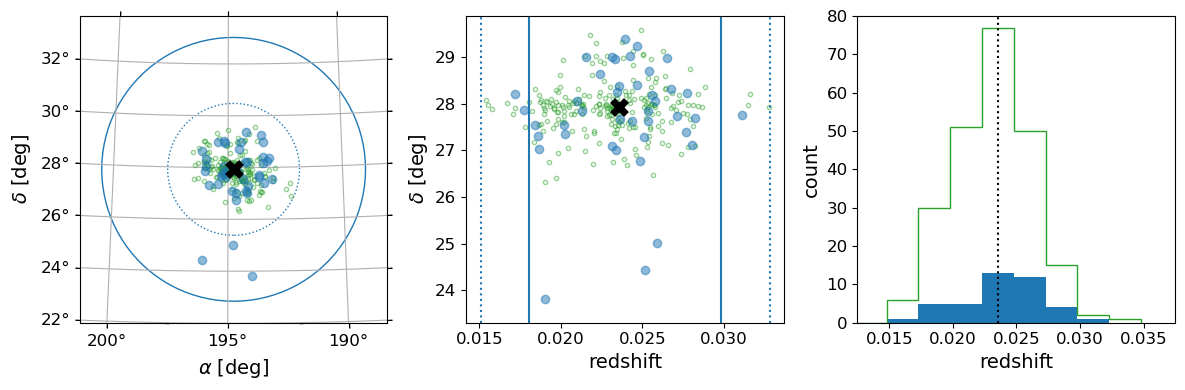

In [10]:
#- Plot the angular coordinates and redshifts
fig = plt.figure(figsize=(12,4), tight_layout=True)
ax = plt.subplot(131, 
                 projection='astro degrees zoom', 
                 center=Coma_coords, 
                 radius=np.arctan(3.5*R2t_Coma/(V_Coma/H0))*u.radian)
ax.grid()

ax.plot(fp_coords.ra.deg, fp_coords.dec.deg, 
        '.', c='tab:green', mfc='none', alpha=0.5, 
        transform=ax.get_transform('world'))
ax.plot(tf_coords.ra.deg, tf_coords.dec.deg, 
        'o', c='tab:blue', alpha=0.5, 
        transform=ax.get_transform('world'))
ax.plot(Coma_coords.ra.deg, 
        Coma_coords.dec.deg, 
        'kx', 
        transform=ax.get_transform('world'), 
        ms=10, 
        mew=5)

inner = SphericalCircle(Coma_coords, 
                        R2t_Coma_angle_1p5, 
                        transform=ax.get_transform('world'), 
                        edgecolor='tab:blue', 
                        linestyle='dotted', 
                        facecolor='none')
ax.add_patch(inner)

outer = SphericalCircle(Coma_coords.transform_to('icrs'), 
                        R2t_Coma_angle_3, 
                        transform=ax.get_transform('world'), 
                        edgecolor='tab:blue', 
                        linestyle='solid', 
                        facecolor='none')
ax.add_patch(outer)

ax.set_xlabel(r'$\alpha$ [deg]', fontsize=14)
ax.set_ylabel(r'$\delta$ [deg]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)


#- Plot the Dec vs redshift and velocity limits
ax = plt.subplot(132)
ax.plot(FP_gals['Z'], fp_coords.dec.deg, '.', c='tab:green', mfc='none', alpha=0.5)
ax.plot(TF_gals['Z'], tf_coords.dec.deg, 'o', c='tab:blue', alpha=0.5)
ax.plot(z_Coma, Coma_coords.dec.deg, 'kx', ms=10, mew=5)

decmin = np.min(tf_coords.dec.deg) - 0.5
decmax = np.max(tf_coords.dec.deg) + 0.5

ax.vlines(np.asarray([V_Coma - 3*sigma_Coma,
                      V_Coma + 3*sigma_Coma,
                      V_Coma - 2*sigma_Coma,
                      V_Coma + 2*sigma_Coma])/c.value,
          decmin, decmax,
          colors='tab:blue',
          linestyles=['dotted', 'dotted', 'solid', 'solid'])

ax.set_xlabel('redshift', fontsize=14)
ax.set_ylabel(r'$\delta$ [deg]', fontsize=14)
ax.set_ylim((decmin, decmax))
ax.tick_params(axis='both', which='major', labelsize=12)


#- Redshift histogram:
zmin = np.min(np.round(TF_gals['Z'], 2)) - 3*bin_width
zmax = np.max(np.round(TF_gals['Z'], 2)) + 3*bin_width

ax = plt.subplot(133)
ax.hist(FP_gals['Z'], bins=z_bins, color='tab:green', histtype='step')
ax.hist(TF_gals['Z'], bins=z_bins)
ax.vlines(z_Coma, 0, 80, colors='k', linestyles='dotted')
ax.set_xlabel('redshift', fontsize=14)
ax.set_ylabel('count', fontsize=14)
ax.set(xlim=(zmin, zmax),
       ylim=(0,80))
ax.tick_params(axis='both', which='major', labelsize=12);